# pH-rate Data AutoFitter

This workbook contains the code and imports the data from multiple files and fits the data to the model..

The data being pklotted is from 'On the Rearrangement in Dioxane/Water of (*Z*)-Arylhydrazones of 5-Amino-3-benzoyl-1,2,4-oxadiazole into (2-Aryl-5-phenyl-2*H*-1,2,3-triazol-4-yl)ureas: Substituent Effects on the Different Reaction Pathways." F. D'Anna, V. Frenna, G. Macaluso, S. Marullo, S. Morganti, V. Pace, D. Spinelli, R. Spisani, C. Tavani, *J. Org. Chem.*, **2006**, *71*, 5616-5624. https://doi.org/10.1021/jo0605849

The data is found in tables within the supplementary material at https://ndownloader.figstatic.com/files/4775281

This notebook will import the pH-rate profile data for each reactant and curve for the profile to obtain kinetic parameters.  It will plot each profile and export each plot as a PDF file and it will collect the data and combine it with Hammett substituent constants from the database.

The output will be the pdf files and a csv file of the kinetic parameters.

## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [2]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
github_location = "./data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

result_file_name = "results.csv"

## Read Data Tables and make Plots

Here we curve fit each set of data and collect the results in a dataframe.

In [3]:
##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = kOH * (KW/H) + kH2O + kH * H/(Ka + H)
    return(np.log10(k_obs))

##############################################################
### Declare list of data files to be used
##############################################################


data_files_info = (["1b-data.csv", "H"],
                   ["1c-data.csv", "p-OCH3"],
                   ["1d-data.csv", "m-CH3"],
                   ["1e-data.csv", "p-CH3"],
                   ["1f-data.csv", "m-Cl"],
                   ["1g-data.csv", "p-Cl"],
                   ["1h-data.csv", "m-Br"],
                   ["1i-data.csv", "p-Br"],
                   ["1j-data.csv", "p-CN"],
                   ["1k-data.csv", "m-NO2"],
                   ["1l-data.csv", "p-NO2"] 
                   )


##############################################################
### Create empty lists to collect data from line fits
##############################################################

n=0
substituent_list = []
molecule_list = []
file_list = []
Ka_list = []
kOH_list = []
kH2O_list = []
kH_list = []
kHKa_list = []
Ka_sd_list = []
kOH_sd_list = []
kH2O_sd_list = []
kH_sd_list = []
kHka_sd_list = []

##############################################################
### Perform a curve fit for each data file, collect results in 
### lists, plot each data set and export pdf files
##############################################################

for line in data_files_info:
    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################


    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    lower_bounds = [0.01, 0.0, 0.0, 0.0]            # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [2,10000,10000,10000]           # upper bounds for Ka, kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)


    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits


    [Ka, kOH, kH2O, kH] = parameters
    perr = np.sqrt(np.diag(pcov))

    [Ka_u, kOH_u, kH2O_u, kH_u] = un.correlated_values(parameters, pcov)

    #######################################################
    ### Print out Parameters and standard deviations    ###
    #######################################################
    if False:
        print(f"Compound {molecule_code}")
        print(f"Ka = {Ka:0.2G} pm {perr[0]:0.2G}")
        print(f"kOH = {kOH:0.3G} pm {perr[1]:0.3G}")
        print(f"kH2O = {kH2O:0.3G} pm {perr[2]:0.3G}")
        print(f"kH = {kH:0.3G} pm {perr[3]:0.3G}")
        print(f"pKa = {-np.log10(Ka):0.2f} \n")

    substituent_list.append(substituent)
    file_list.append(datafile_name)
    molecule_list.append(molecule_code)
    Ka_list.append(Ka_u.n)
    kOH_list.append(kOH_u.n)
    kH2O_list.append(kH2O_u.n)
    kH_list.append(kH_u.n)
    kHka_u = kH_u/Ka_u
    kHKa_list.append(kHka_u.n)
    Ka_sd_list.append(Ka_u.s)
    kOH_sd_list.append(kOH_u.s)
    kH2O_sd_list.append(kH2O_u.s)
    kH_sd_list.append(kH_u.s)
    kHka_sd_list.append(kHka_u.s)


    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 14 + step, step)   # make an array of points to calculate y-values from
    y1 = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model

    style_file = "tufte.mplstyle"
    plt.style.use(github_location_styles + style_file)        
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
    ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
    
    ############################
    ### Set labels and scale ###
    ############################
    
    ax.set(
    #    title="pH rate profilr",       
              ylabel=r"$\log{k_{obs}}$", 
              xlabel=r"$pS^+$",                
              xlim=[-2,14],                  
              ylim=[-7,0]
             )
    
    #########################################
    ### Plot the data                     ###
    #########################################
    
    
    plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)
    
    ax.scatter(x,y, s=64, color="white",  edgecolors = "none", zorder=2)
    ax.scatter(x,y, s=32, color="black",  edgecolors = "none", zorder=2)
    ax.scatter(x,y, s=16, color="white",  edgecolors = "none", alpha = 1.0, zorder=2)
    
    
    #########################################
    ### Plot the line fit.                ###
    #########################################
    
    ax.plot(x1, y1, color='black', zorder=0, linewidth=0.7)
    plt.text(4, -3, molecule_code+"  "+ substituent) 


    fig.savefig("plots/plot"+ molecule_code +".pdf")   # use this to save the figure in PDF format
#    plt.show()                 # output the combined plot plots
    plt.close()



    

##############################################

df1 = pd.DataFrame(data = {'Substituent':substituent_list,
                           'file':file_list, 
                           'molecule':molecule_list, 
                           'Ka':Ka_list, 
                           'kOH':kOH_list, 
                           'kH2O':kH2O_list, 
                           'kH':kH_list, 
                           'kHKa':kHKa_list, 
                           'Ka_sd':Ka_sd_list, 
                           'kOH_sd':kOH_sd_list, 
                           'kH2O_sd':kH2O_sd_list, 
                           'kH_sd':kH_sd_list,
                           'kHKa_sd':kHka_sd_list})
display(df1)



,Substituent,file,molecule,Ka,kOH,kH2O,kH,kHKa,Ka_sd,kOH_sd,kH2O_sd,kH_sd,kHKa_sd
0,H,1b-data.csv,1b,0.559668,1.310814,6.619636e-06,0.001902,0.003399,0.100101,0.047005,3.460167e-07,0.000239,0.000222
1,p-OCH3,1c-data.csv,1c,0.468179,2.176537,1.244626e-05,0.002322,0.004959,0.077796,0.063239,4.121481e-07,0.000304,0.000260
2,m-CH3,1d-data.csv,1d,0.591199,1.367986,8.775740e-06,0.002061,0.003486,0.090153,0.039806,3.291873e-07,0.000252,0.000153
3,p-CH3,1e-data.csv,1e,0.452471,1.563831,1.197328e-05,0.001956,0.004324,0.055863,0.039574,3.418706e-07,0.000182,0.000194
4,m-Cl,1f-data.csv,1f,1.023843,10.732163,2.539286e-06,0.000775,0.000757,0.297194,0.401754,1.372111e-07,0.000187,0.000050
5,p-Cl,1g-data.csv,1g,0.807549,6.305972,3.822434e-06,0.000959,0.001188,0.231587,0.281435,2.267200e-07,0.000228,0.000083
6,m-Br,1h-data.csv,1h,0.959064,11.644248,2.417490e-06,0.000687,0.000716,0.260561,0.437624,1.245553e-07,0.000152,0.000049
7,p-Br,1i-data.csv,1i,0.973985,7.725533,3.286770e-06,0.000957,0.000983,0.336623,0.352477,2.020912e-07,0.000276,0.000078
8,p-CN,1j-data.csv,1j,1.100795,143.937370,8.245923e-07,0.000221,0.000201,0.368629,5.779475,6.531362e-08,0.000062,0.000015
9,m-NO2,1k-data.csv,1k,1.356759,75.301953,9.372250e-07,0.000298,0.000219,0.625832,3.557652,7.173141e-08,0.000120,0.000018


## Combine with Hammett Data and Write Result Table

read in the data set created above and Hammett parameters.  Now combine with the data from above then edit and export the dataframe as a csv file.

In [4]:
#################################################################
### a function to fill in sigma for empty spaces in s+ and s- 
#################################################################
def fill_sigma(df):     
    for z in df.index:
        if np.isnan(df.loc[z,"s_plus"]):
            df.loc[z,"s_plus"] = df.loc[z,"sigma"]
        if np.isnan(df["s_minus"][z]):
            df.loc[z,"s_minus"] = df.loc[z,"sigma"]
    return(df)

################################################################################
### Read Hammett data set. The fields are separated by commas; comments are enabled  
################################################################################

LFER_Data = "LFER_HanschLeoTaft2.csv"   # Choose which set of Hammett parameters you prefer
#LFER_Data = "LFER_Williams.csv"

Filename = github_location_LFER_tables + LFER_Data

df2 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="Substituent", 
                 comment = "#") 

########################################################
### Fill across sigma values and select substituents 
########################################################

df2 = fill_sigma(df2)

###############################
### Remove unneeded columns 
###############################
 
df2.drop(labels = ["TABLE V", "TABLE I"],    #Trim "LFER_HanschLeoTaft.csv" data
#df2.drop(labels = ["Page"],                   #Trim "LFER_Williams.csv"" data
        axis = 1,
        inplace = True)


########################################################
### Combine data sets
########################################################

df3 = df1.set_index('Substituent')


#display(df1)
#display(df2)

result = pd.concat([df2, df3], axis=1, join="inner")

### Trim unneeded data
#result.drop(labels = ["Unnamed: 0", "file"],axis = 1, inplace=True) 

result.sort_values(by=['sigma'], inplace=True)

display(result)

result.to_csv(result_file_name, float_format ="%.4G")


,sigma,s_plus,s_minus,sigma_I,sigma_n,sigma_star,F,R,R+,R-,...,Ka,kOH,kH2O,kH,kHKa,Ka_sd,kOH_sd,kH2O_sd,kH_sd,kHKa_sd
Substituent,,,,,,,,,,,,,,,,,,,,,
p-OCH3,-0.27,-0.78,-0.27,0.29,-0.09,0.52,0.29,-0.56,-1.07,-0.55,...,0.468179,2.176537,1.244626e-05,0.002322,0.004959,0.077796,0.063239,4.121481e-07,0.000304,0.000260
p-CH3,-0.17,-0.31,-0.17,-0.01,-0.10,-0.10,0.01,-0.18,-0.32,-0.18,...,0.452471,1.563831,1.197328e-05,0.001956,0.004324,0.055863,0.039574,3.418706e-07,0.000182,0.000194
m-CH3,-0.07,-0.07,-0.07,NaN,NaN,NaN,NaN,0.00,0.00,0.00,...,0.591199,1.367986,8.775740e-06,0.002061,0.003486,0.090153,0.039806,3.291873e-07,0.000252,0.000153
H,0.00,0.00,0.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,...,0.559668,1.310814,6.619636e-06,0.001902,0.003399,0.100101,0.047005,3.460167e-07,0.000239,0.000222
p-Cl,0.23,0.11,0.23,0.47,0.29,1.05,0.42,-0.19,-0.31,-0.23,...,0.807549,6.305972,3.822434e-06,0.000959,0.001188,0.231587,0.281435,2.267200e-07,0.000228,0.000083
p-Br,0.23,0.15,0.23,0.47,0.30,1.00,0.45,-0.22,-0.30,-0.20,...,0.973985,7.725533,3.286770e-06,0.000957,0.000983,0.336623,0.352477,2.020912e-07,0.000276,0.000078
m-Cl,0.37,0.37,0.37,NaN,NaN,NaN,NaN,0.00,0.00,0.00,...,1.023843,10.732163,2.539286e-06,0.000775,0.000757,0.297194,0.401754,1.372111e-07,0.000187,0.000050
m-Br,0.39,0.39,0.39,NaN,NaN,NaN,NaN,0.00,0.00,0.00,...,0.959064,11.644248,2.417490e-06,0.000687,0.000716,0.260561,0.437624,1.245553e-07,0.000152,0.000049
p-CN,0.66,0.66,1.00,0.70,0.66,1.30,0.51,0.15,0.15,0.49,...,1.100795,143.937370,8.245923e-07,0.000221,0.000201,0.368629,5.779475,6.531362e-08,0.000062,0.000015


In [5]:
#### MAKE LARGE MULTIPLOT OF CURVE FITS
#
# Code for multiplot grid stolen from
# github/blinkletter/StealThisCode/testideas/DataAnalyzer2.ipynb
# and github/blinkletter/StealThisCode/testideas/BiochemToolbox.py

##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = kOH * (KW/H) + kH2O + kH * H/(Ka + H)
    return(np.log10(k_obs))

##############################################################
### Declare list of data files to be used
##############################################################


data_files_info = (["1b-data.csv", "H"],
                   ["1c-data.csv", "p-OCH3"],
                   ["1d-data.csv", "m-CH3"],
                   ["1e-data.csv", "p-CH3"],
                   ["1f-data.csv", "m-Cl"],
                   ["1g-data.csv", "p-Cl"],
                   ["1h-data.csv", "m-Br"],
                   ["1i-data.csv", "p-Br"],
                   ["1j-data.csv", "p-CN"],
                   ["1k-data.csv", "m-NO2"],
                   ["1l-data.csv", "p-NO2"] 
                   )



###########
### Set up Plot grid
###########

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=4, 
                       ncols=3, 
                       figsize=(7,10), 
                    #   sharex=True, 
                    #   sharey=True
                       )  
n = 0  ### set counter


##############################################################
### Perform a curve fit for each data file, collect results in 
### lists, plot each data set and export pdf files
##############################################################

for line in data_files_info:

    plot_row = n // 3   ### use counter to get column and row
    plot_col = n % 3

    ax[plot_row][plot_col].set(
                xlabel = None, 
                ylabel = None,
        #        title = "Lane # "+lane_name,
                xlim = [-1, 13],                  
                ylim = [-6.6, 0]
        )
    
    ### Column 0 gets y-axis label and ticks.
    ax[plot_row][0].set(ylabel= r"$k{obs}$")
    ax[plot_row][0].set_yticks([-5,-3,-1])
    ### Columns 1 & 2 get no y-axis ticks.
    ax[plot_row][1].set_yticks([])
    ax[plot_row][2].set_yticks([])

    ### Row 3 (bottom) gets x-axis label and ticks.
    ax[3][plot_col].set(xlabel= r"$pH$")
    ax[0][plot_col].set_xticks([])
    ### Other rows get no x-axis ticks.
    ax[1][plot_col].set_xticks([])
    ax[2][plot_col].set_xticks([])




    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

#    ax[plot_row][plot_col].text(0, 3.4, molecule_code) 
#    ax[plot_row][plot_col].text(0, 3.0, substituent) 


    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################


    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    lower_bounds = [0.01, 0.0, 0.0, 0.0]            # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [10000,10000,10000,10000]           # upper bounds for Ka, kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)


    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits


    [Ka, kOH, kH2O, kH] = parameters
    perr = np.sqrt(np.diag(pcov))

    [Ka_u, kOH_u, kH2O_u, kH_u] = un.correlated_values(parameters, pcov)


    step = 0.1
    x1 = np.arange(-2, 14 + step, step)   # make an array of points to calculate y-values from
    y1 = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model

    
    #########################################
    ### Plot the data                     ###
    #########################################
    
    
    #plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)
    
    ax[plot_row][plot_col].scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
    ax[plot_row][plot_col].scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1.0, zorder=2)
    ax[plot_row][plot_col].scatter(x,y, s=32, color="black",  edgecolors = "none", alpha = 0.1, zorder=2)
    
    
    #########################################
    ### Plot the line fit.                ###
    #########################################
    
    ax[plot_row][plot_col].plot(x1, y1, color='black', zorder=0, linewidth=0.7)
    ax[plot_row][plot_col].text(0, -0.4, molecule_code+"  "+ substituent) 

    n += 1    ### increment counter

#####################
### Fix specific axis labels (11 plots in 12 plot grid left blank square)
#####################

    ax[3][2].set_xticks([])
    ax[2][2].set_xticks([0,5,10])
    ax[3][2].set(xlabel= r"")
    ax[2][2].set(xlabel= r"$pH$")


#####################
fig.savefig("images/plot_ALL_Multiplot.pdf")   # use this to save the figure in PDF format
#    plt.show()                 # output the combined plot plots
plt.close()





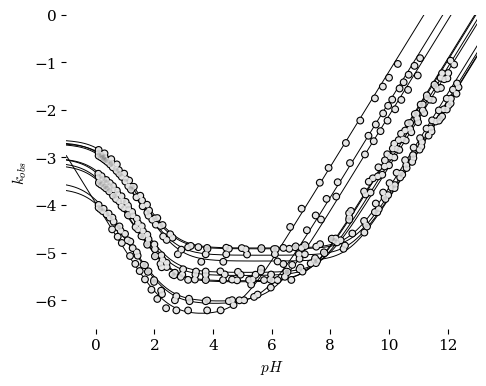

In [6]:
#### ALL ON ONE PLOT

##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = kOH * (KW/H) + kH2O + kH * H/(Ka + H)
    return(np.log10(k_obs))

##############################################################
### Declare list of data files to be used
##############################################################


data_files_info = (["1b-data.csv", "H"],
                   ["1c-data.csv", "p-OCH3"],
                   ["1d-data.csv", "m-CH3"],
                   ["1e-data.csv", "p-CH3"],
                   ["1f-data.csv", "m-Cl"],
                   ["1g-data.csv", "p-Cl"],
                   ["1h-data.csv", "m-Br"],
                   ["1i-data.csv", "p-Br"],
                   ["1j-data.csv", "p-CN"],
                   ["1k-data.csv", "m-NO2"],
                   ["1l-data.csv", "p-NO2"] 
                   )


###########
### Set up Plot grid
###########

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, 
                       ncols=1, 
                       figsize=(5,4), 
                    #   sharex=True, 
                    #   sharey=True
                       )  
n = 0  ### set counter

size1 = 32  # sizes for data points
size2 = 16

ax.set(
            xlabel = r"$pH$", 
            ylabel = r"$k_{obs}$",
    #        title = "Lane # "+lane_name,
            xlim = [-1, 13],                  
            ylim = [-6.6, 0] 
    )
##############################################################
### Perform a curve fit for each data file, collect results in 
### lists, plot each data set and export pdf files
##############################################################

for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    lower_bounds = [0.01, 0.0, 0.0, 0.0]            # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [10000,10000,10000,10000]           # upper bounds for Ka, kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    [Ka, kOH, kH2O, kH] = parameters
    perr = np.sqrt(np.diag(pcov))

    [Ka_u, kOH_u, kH2O_u, kH_u] = un.correlated_values(parameters, pcov)

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-1, 13 + step, step)   # make an array of points to calculate y-values from
    y1 = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model

        
    #########################################
    ### Plot the line fit.                ###
    #########################################
    
    ax.plot(x1, y1, color='black', zorder=0, linewidth=0.7)

for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    
    #########################################
    ### Plot the data                     ###
    #########################################
        
    ax.scatter(x,y, s=size1, color="black",  edgecolors = "none", zorder=2)
    
    

for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    #########################################
    ### Plot the data                     ###
    #########################################
        
    ax.scatter(x,y, s=size2, color="white",  edgecolors = "none", alpha = 1.0, zorder=2)



for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    #########################################
    ### Plot the data                     ###
    #########################################
        
    ax.scatter(x,y, s=size2, color="black",  edgecolors = "none", alpha = 0.1, zorder=2)
    


fig.savefig("images/plot_ALL_ONE.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots
plt.close()





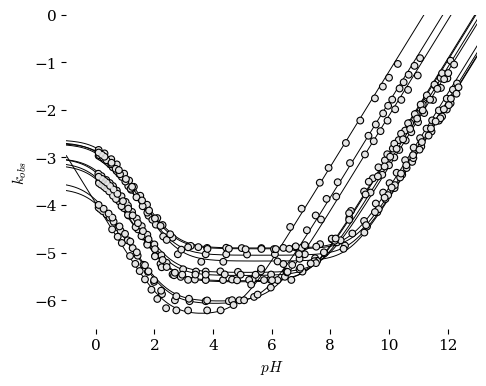

In [7]:
#### ALL ON ONE PLOT

##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = kOH * (KW/H) + kH2O + kH * H/(Ka + H)
    return(np.log10(k_obs))

##############################################################
### Declare list of data files to be used
##############################################################


data_files_info = (["1b-data.csv", "H"],
                   ["1c-data.csv", "p-OCH3"],
                   ["1d-data.csv", "m-CH3"],
                   ["1e-data.csv", "p-CH3"],
                   ["1f-data.csv", "m-Cl"],
                   ["1g-data.csv", "p-Cl"],
                   ["1h-data.csv", "m-Br"],
                   ["1i-data.csv", "p-Br"],
                   ["1j-data.csv", "p-CN"],
                   ["1k-data.csv", "m-NO2"],
                   ["1l-data.csv", "p-NO2"] 
                   )


###########
### Set up Plot grid
###########

plt.ioff()      ### switch off interactive display of plots. plt.show() needed to display a plot now
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, 
                       ncols=1, 
                       figsize=(5,4), 
                    #   sharex=True, 
                    #   sharey=True
                       )  
n = 0  ### set counter

size1 = 32  # sizes for data points
size2 = 16

ax.set(
            xlabel = r"$pH$", 
            ylabel = r"$k_{obs}$",
    #        title = "Lane # "+lane_name,
            xlim = [-1, 13],                  
            ylim = [-6.6, 0] 
    )
##############################################################
### Perform a curve fit for each data file, collect results in 
### lists, plot each data set and export pdf files
##############################################################

for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    lower_bounds = [0.01, 0.0, 0.0, 0.0]            # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [10000,10000,10000,10000]           # upper bounds for Ka, kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    [Ka, kOH, kH2O, kH] = parameters
    perr = np.sqrt(np.diag(pcov))

    [Ka_u, kOH_u, kH2O_u, kH_u] = un.correlated_values(parameters, pcov)

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-1, 13 + step, step)   # make an array of points to calculate y-values from
    y1 = model(x1, Ka, kOH, kH2O, kH)     # Calculate those y-values using the model

        
    #########################################
    ### Plot the line fit.                ###
    #########################################
    
    ax.plot(x1, y1, color='black', zorder=0, linewidth=0.7)

for line in data_files_info:

    datafile_name = line[0]
    substituent = line[1]
    molecule_code = datafile_name[0:2]

    df = pd.read_csv(github_location + datafile_name, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 

    #########################################################
    ### Determine scale from column header name           ###
    #########################################################
    
    if df.columns[0] == "k(A,R)x10^5":
        name = "k(A,R)x10^5"
        colname = df.columns[0]
        factor = 10**-5
    elif df.columns[0] == "k(A,R)x10^4":
        name = "k(A,R)x10^4"
        colname = df.columns[0]
        factor = 10**-4
    else:
        name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
        colname = df.columns[0]
        factor = 0

    
    ###############################
    ### Calculations            ###
    ###############################

    df["log_k"] = np.log10(df[name] * factor)

    ###############################
    ### Curve Fit to model      ###
    ###############################

    x = df.index
    y = df["log_k"]

    
    #########################################
    ### Plot the data                     ###
    #########################################
        
    ax.scatter(x,y, s=size1, color="black",  edgecolors = "none", zorder=2)
    ax.scatter(x,y, s=size2, color="white",  edgecolors = "none", alpha = 1.0, zorder=2)
    ax.scatter(x,y, s=size2, color="black",  edgecolors = "none", alpha = 0.1, zorder=2)
    
    



fig.savefig("images/plot_ALL_ONE2.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots
plt.close()



